# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import anndata
import scanpy as sc
import scanpy_scripts as ss

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
ss.lib.set_figsize((4, 4))
expr_cmap = ss.lib.expression_colormap()

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data

In [2]:
h5ads = !ls ../data/byrd20/byrd_006_counts_ATL_*_filtered_feature_bc_matrix.h5 | sort
h5ads

['../data/byrd20/byrd_006_counts_ATL_01_filtered_feature_bc_matrix.h5',
 '../data/byrd20/byrd_006_counts_ATL_02_2_filtered_feature_bc_matrix.h5',
 '../data/byrd20/byrd_006_counts_ATL_03_2_filtered_feature_bc_matrix.h5',
 '../data/byrd20/byrd_006_counts_ATL_05_2_filtered_feature_bc_matrix.h5']

In [3]:
raw_ads = [sc.read_10x_h5(h5ad) for h5ad in h5ads]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
scr_dfs = [ss.lib.run_scrublet(rad, inplace=False) for rad in raw_ads]

In [5]:
for i, scr_df in enumerate(scr_dfs):
    raw_ads[i].obs['scrublet_score'] = scr_df['scrublet_score'].values
    raw_ads[i].obs['scrublet_score_z'] = scr_df['scrublet_score_z'].values
    raw_ads[i].obs['bh_pval'] = scr_df['bh_pval'].values
    raw_ads[i].obs_names = pd.Series(raw_ads[i].obs_names).str.partition('-')[0].values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
raw_ad = anndata.AnnData.concatenate(*raw_ads, batch_categories=['1', '2', '3', '4'])

Making variable names unique for controlled concatenation.


In [7]:
raw_ad.var = raw_ad.var[['gene_ids-1']].rename(columns={'gene_ids-1': 'gene_ids'})

In [8]:
raw_ad.write('human_gingival.raw.h5ad', compression='lzf')

# Process

In [9]:
raw_ad = sc.read('human_gingival.raw.h5ad')

## QC

In [10]:
ss.lib.calculate_qc(raw_ad)

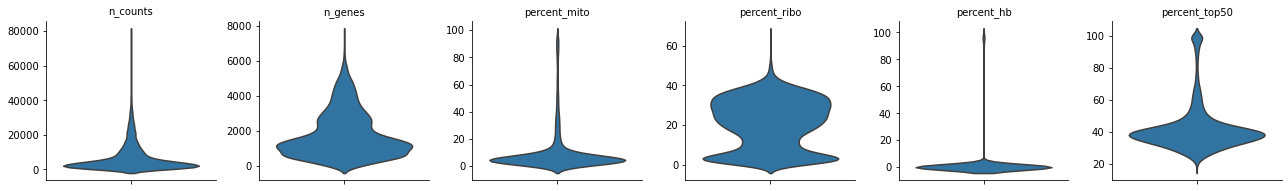

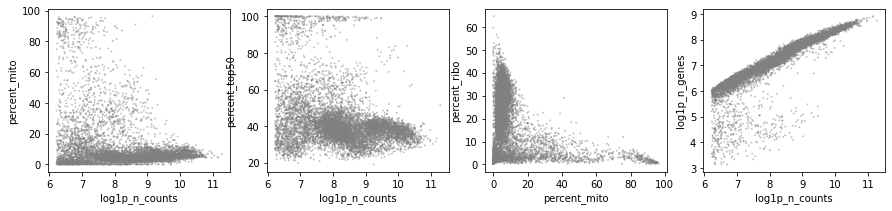

In [11]:
ss.lib.plot_qc(raw_ad)

In [12]:
raw_ad1 = ss.lib.remove_genes(raw_ad, ['mito', 'ribo'])

## Cluster

In [13]:
ad1 = ss.lib.simple_default_pipeline(
    raw_ad1, batch='batch', batch_method='bbknn',
    filter_kw={'metrics': ['n_counts', 'percent_mito', 'percent_hb', 'percent_top50'], 'max_hb': 0.2},
    hvg_kw={'by_batch': ['batch', 2]},
)

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [14]:
ad1

AnnData object with n_obs × n_vars = 6683 × 20917 
    obs: 'batch', 'bh_pval', 'scrublet_score', 'scrublet_score_z', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'leiden_bk_r0_7', 'leiden_bk_r0_9'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'n_genes', 'highly_variable'
    uns: 'leiden', 'neighbors_bk', 'pca'
    obsm: 'X_pca', 'X_umap_bk'
    varm: 'PCs'

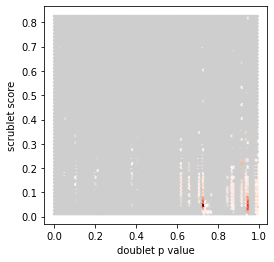

In [15]:
ss.lib.set_figsize((4, 4))
plt.hexbin(ad1.obs.bh_pval, ad1.obs.scrublet_score, cmap=expr_cmap);
plt.xlabel('doublet p value');
plt.ylabel('scrublet score');

In [16]:
ad1.obs['is_doublet'] = (ad1.obs.bh_pval < 0.6) & (ad1.obs.scrublet_score > 0.3)
ad1.obs['is_doublet'] = ad1.obs['is_doublet'].astype('category')

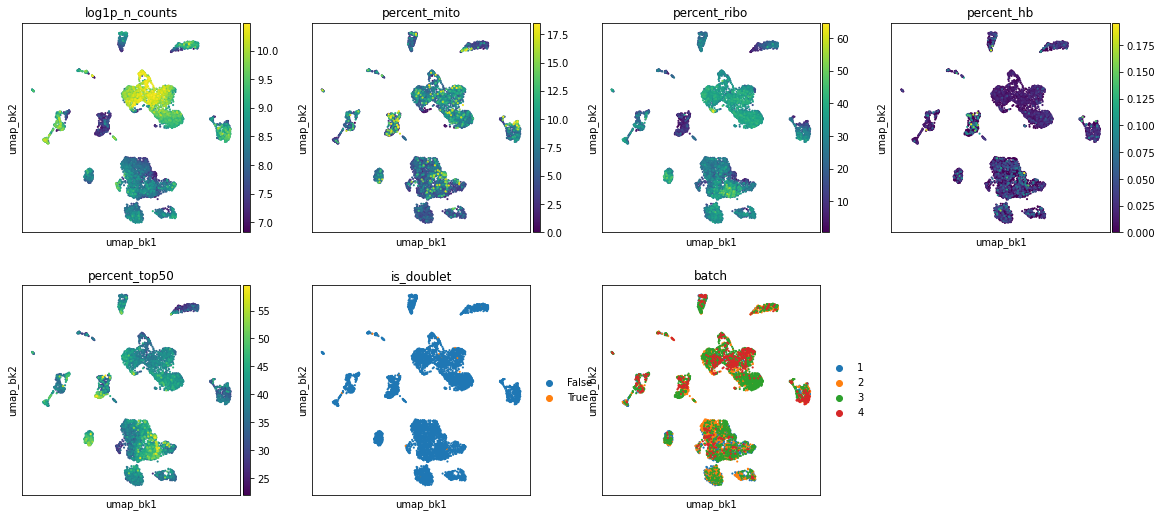

In [17]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(
    ad1, basis='umap_bk',
    color=['log1p_n_counts', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'is_doublet', 'batch'], ncols=4)

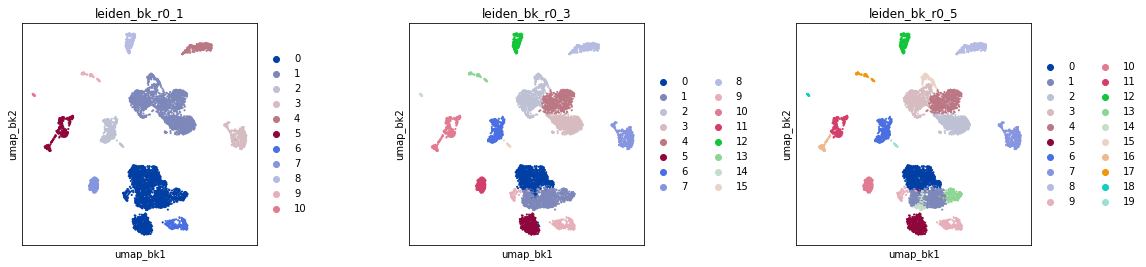

In [18]:
ss.lib.plot_scatter(ad1, basis='umap_bk', color=['leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5'], wspace=0.5)

## Annotation

In [19]:
markers = [
    'MKI67',
    'CD3D', 'CD40LG', 'CD8B', 'FOXP3', 'SLC4A10', 'TRAV1-2',
    'NCAM1', 'KRT81', 'TRGV5', 'TRDV1',
    'MS4A1', 'JCHAIN', 'CLEC4C', 'LYZ', 'TPSB2',
    'CCL21', 'ACKR1', 'CXCL12',
    'KRT15', 'KRT1', 'KRTDAP', 'KRT6A', 'KRT19', 'SFRP1', 'SOX6', 'CCER2', 'KRT20',
    'PMEL', 'COL3A1', 'ACTA2'
]

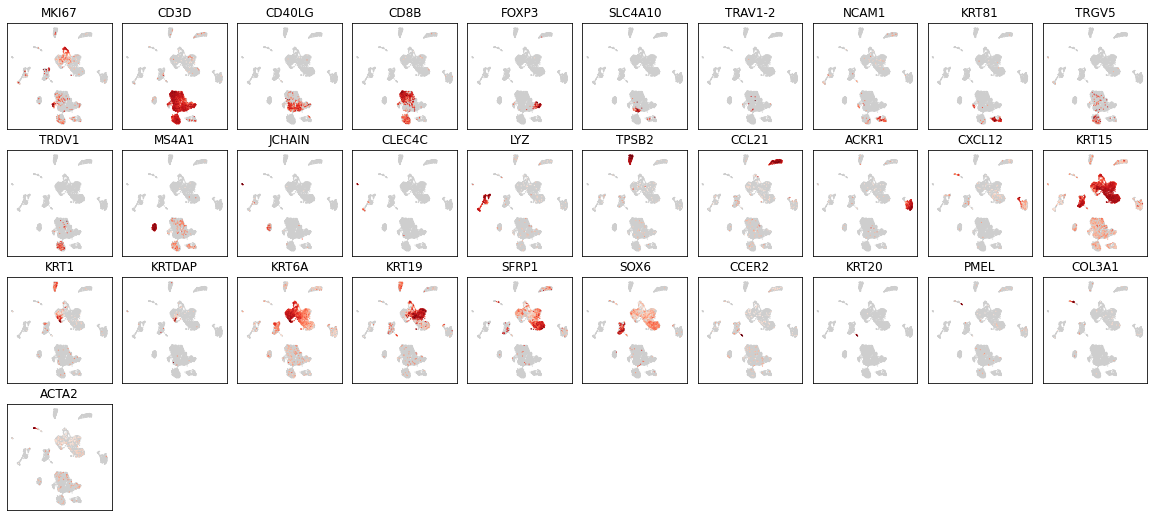

In [20]:
ss.lib.set_figsize((2, 2))
ss.lib.plot_genes(
    ad1, basis='umap_bk', size=5, color_map=expr_cmap, vmin=0,
    genes=markers
)

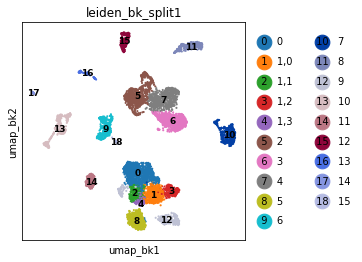

In [21]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=('leiden_bk_r0_3', ['1']), resolution=0.2, key_added='bk_split1')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split1', wspace=0.4, figsize=(4, 4));

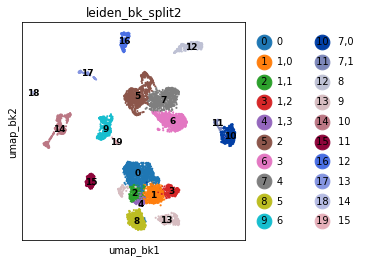

In [22]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=('leiden_bk_split1', ['7']), resolution=0.1, key_added='bk_split2')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split2', wspace=0.4, figsize=(4, 4));

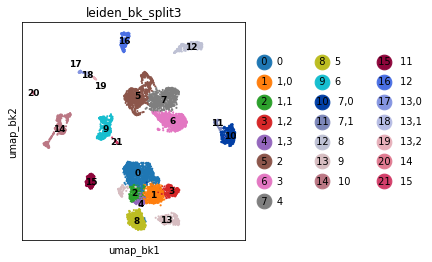

In [23]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=('leiden_bk_split2', ['13']), resolution=0.1, key_added='bk_split3')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split3', wspace=0.4, figsize=(4, 4));

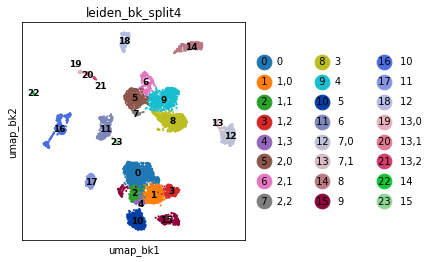

In [24]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=('leiden_bk_split3', ['2']), resolution=0.15, key_added='bk_split4')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split4', wspace=0.4, figsize=(4, 4));

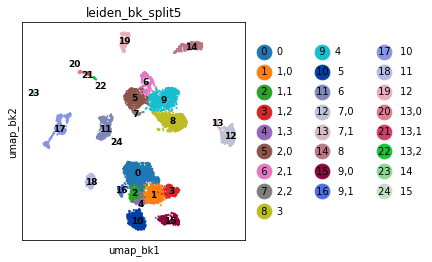

In [25]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=('leiden_bk_split4', ['9']), resolution=0.05, key_added='bk_split5')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split5', wspace=0.4, figsize=(4, 4));

In [26]:
ad1.obs['annot0'] = ss.lib.regroup(ad1, groupby='leiden_bk_split5', regroups={
    'Basal 1': '3',
    'Basal 2': '4',
    'Basal 3': '6',
    'Basal 4': '2,0',
    'Basal cycling': '2,1',
    'Suprabasal': '2,2',
    'Melanocyte': '13,2',
    'Mercel': '15',
    'Venule': '7,0',
    'Arterial/Cap': '7,1',
    'Lymphatic': '8',
    'Smooth muscle': '13,0',
    'Fibroblast': '13,1',
    'Th': ['1,0', '1,1'],
    'Treg': '1,2',
    'Tc': '0',
    'gdT': '5',
    'MAIT': '1,3',
    'NK': '9,0',
    'T/NK cycling': '9,1',
    'B/plasma': '11',
    'pDC': '14',
    'Mast': '12',
    'Myeloid': '10',
})

In [27]:
myl_ad1 = ad1[ad1.obs.annot0=='Myeloid', :].copy()

In [28]:
ss.lib.simple_default_pipeline(myl_ad1, batch='batch', batch_method='bbknn', post_norm_only=True, hvg_kw={'by_batch': ['batch', 2]})

AnnData object with n_obs × n_vars = 287 × 12599 
    obs: 'batch', 'bh_pval', 'scrublet_score', 'scrublet_score_z', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'leiden_bk_r0_7', 'leiden_bk_r0_9', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'leiden_bk_split4', 'leiden_bk_split5', 'annot0'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'n_genes', 'highly_variable', 'highly_variable_nbatches'
    uns: 'leiden', 'neighbors_bk', 'pca', 'is_doublet_colors', 'batch_colors', 'leiden_bk_r0_1_colors', 'leiden_bk_r0_3_colors', 'leiden_bk_r0_5_colors', 'leiden_bk_split1_colors', 'leiden_bk_split2_colors', 'leiden_bk_split3_colors', 'leiden_bk_split4_colors', 'leiden_bk_split5_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap_bk'
    varm: 'PCs'

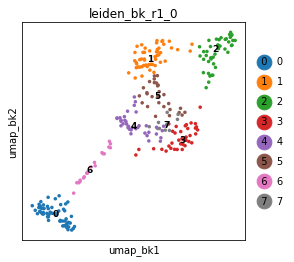

In [29]:
ss.lib.leiden(myl_ad1, use_graph='neighbors_bk', resolution=[1.0], key_added='bk')
ss.lib.plot_embedding(myl_ad1, basis='umap_bk', groupby='leiden_bk_r1_0', size=50);

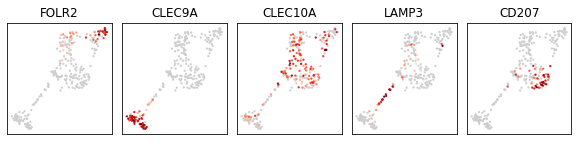

In [30]:
ss.lib.set_figsize((3, 3))
ss.lib.plot_genes(
    myl_ad1, basis='umap_bk', size=20, color_map=expr_cmap,
    genes=['FOLR2', 'CLEC9A', 'CLEC10A', 'LAMP3', 'CD207']
);

In [31]:
myl_ad1.obs['annot0'] = ss.lib.regroup(myl_ad1, groupby='leiden_bk_r1_0', regroups={
    'DC1': '0',
    'DC2': ['1', '4', '5', '7'],
    'activated DC': '6',
    'Langerhans': '3',
    'Mac': '2'
})

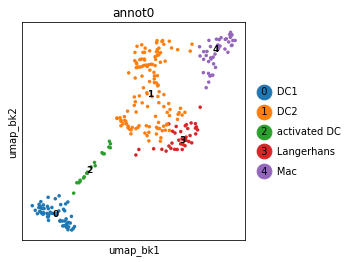

In [32]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_embedding(myl_ad1, basis='umap_bk', groupby='annot0', size=50);

In [34]:
ad1.obs['annot1'] = ad1.obs['annot0'].astype(str)
ad1.obs.loc[ad1.obs.annot0=='Myeloid', 'annot1'] = myl_ad1.obs.annot0.astype(str).values
ad1.obs['annot1'] = ad1.obs['annot1'].astype('category')
ad1.obs.annot1.cat.reorder_categories([
    'Basal 1', 'Basal 2', 'Basal 3', 'Basal 4', 'Basal cycling', 'Suprabasal', 'Melanocyte', 'Mercel',
    'Venule', 'Arterial/Cap', 'Lymphatic', 'Smooth muscle', 'Fibroblast',
    'Th', 'Treg', 'Tc', 'gdT', 'MAIT', 'NK', 'T/NK cycling', 'B/plasma', 'pDC', 'Mast',
    'DC1', 'DC2', 'activated DC', 'Langerhans', 'Mac',
], inplace=True)

In [35]:
ad2 = ad1[~ad1.obs.is_doublet.astype(bool)].copy()

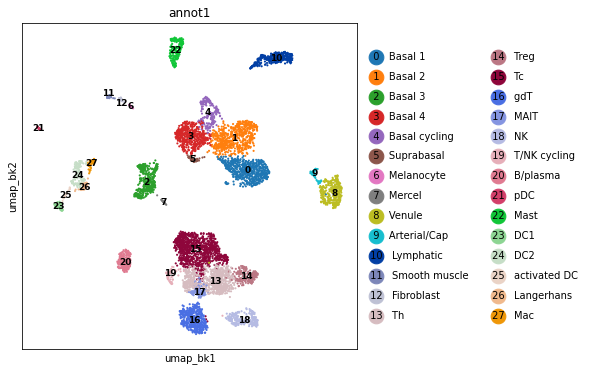

In [36]:
ss.lib.clear_colors(ad2)
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='annot1', wspace=0.4, figsize=(6, 6));

In [37]:
ad2.write('human_gingiva.processed.h5ad', compression='gzip')

## Markers

In [38]:
mkst = ss.lib.calc_marker_stats(ad2, groupby='annot1')

In [39]:
mks = ss.lib.filter_marker_stats(mkst[2], min_frac_diff=0.05, max_next_frac=0.5, how='and', single=False)

In [40]:
deg = ss.lib.test_markers(ad2, mks, groupby='annot1')

In [41]:
deg1 = deg.loc[lambda x: x.pvals < 0.01].copy()

In [42]:
deg1s = deg1.groupby('cluster', sort=False).apply(lambda x: x.sort_values(['frac_diff', 'pvals_adj'], ascending=[False, True])).reset_index(drop=True)

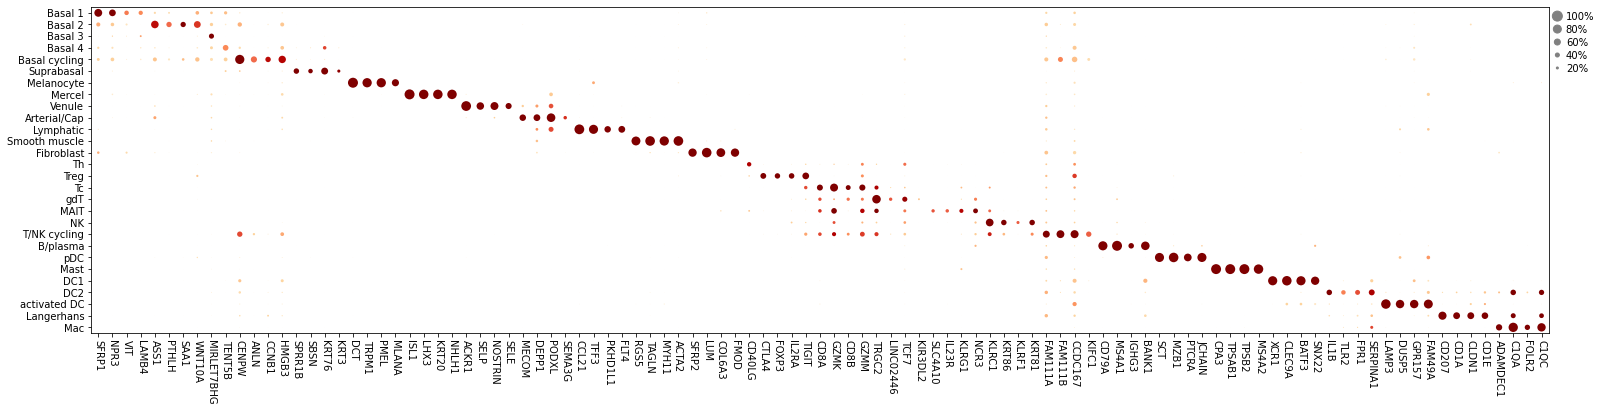

In [43]:
ss.lib.dotplot2(ad2, deg1s.groupby('cluster', sort=False).head(4).genes.to_list(), groupby='annot1', color_map='OrRd', swap_axis=True);

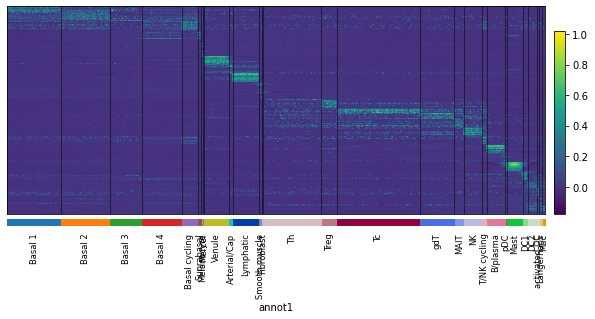

In [44]:
sc.pl.heatmap(ad2, deg1s.groupby('cluster', sort=False).head(10).genes.to_list(), groupby='annot1', standard_scale='var', swap_axes=True);

## SARS-CoV-2 entry factors

In [45]:
covid_markers_human = [
    'ACE2', 'TMPRSS2', 'BSG', 'TFRC', 'CTSL', 'CTSB', 'TMPRSS4', 'TMPRSS11D', 'LY6E',
    'IFITM1', 'IFITM2', 'IFITM3', 'GSK3', 'HNRNPA1', 'FURIN', 'DDX3X', 'MADP1', 'TOP3B',
    'DPP4', 'STGAL4', 'ST3GAL1', 'ST14', 'ANPEP', 'VCP', 'FIIT1', 'IFIT2', 'IFIT3', 'CDHR3',
    'CD209', 'CLEC4G', 'CLEC4M', 'CHMP2A', 'ORF98', 'AP2A2', 'AP2M1', 'TAPT1', 'RHOA',
    'RAB14', 'RAB10', 'NSP7', 'RAB1A', 'ZCRB1'
]

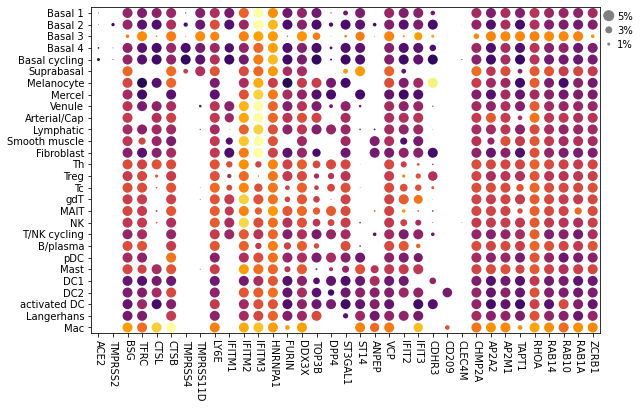

In [46]:
ss.lib.dotplot2(
    ad2, [g for g in covid_markers_human if g in ad2.raw.var_names], groupby='annot1',
    vmin=0, vmax=3, mean_only_expressed=True, dot_max=0.05, color_map='inferno', swap_axis=True,
);